In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

/Users/xiachunxuan/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/xiachunxuan/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/7v/0pft7_9d053gl9jmqh7tn0sr0000gn/T/ipykernel_2693/1184483170.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = df.groupby('StockID').apply(analyze_correlation)


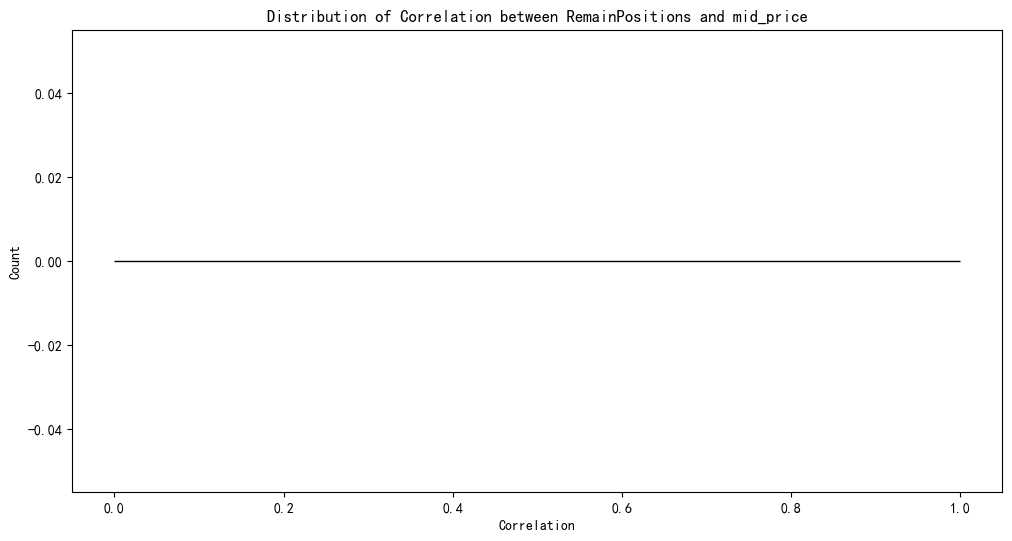

In [2]:

# 读取数据
df = pd.read_csv('./data_collection/snapshots/20240828-001043-day32_all_stocks.csv')


# 计算mid_price
df['mid_price'] = (df['AskPrice1'] * df['AskVolume1']+ df['BidPrice1'] * df['BidVolume1']) / (df['AskVolume1'] + df['BidVolume1'])

# 分析RemainPositions和mid_price的相关性
def analyze_correlation(group):
    return pd.Series({
        'correlation': group['RemainPositions'].corr(group['mid_price']),
        'avg_remain_positions': group['RemainPositions'].mean(),
        'avg_mid_price': group['mid_price'].mean()
    })

correlation_results = df.groupby('StockID').apply(analyze_correlation)

# 可视化相关性
plt.figure(figsize=(12, 6))
sns.histplot(correlation_results['correlation'], kde=True)
plt.title('Distribution of Correlation between RemainPositions and mid_price')
plt.xlabel('Correlation')
plt.show()

In [ ]:
# 分析RemainPositions和TargetPositions的差异
df['PositionDifference'] = df['RemainPositions'] - df['TargetPositions']

# 可视化每只股票的PositionDifference随时间的变化
fig, axes = plt.subplots(5, 10, figsize=(30, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, stock_id in enumerate(df['StockID'].unique()):
    stock_data = df[df['StockID'] == stock_id]
    axes[i].plot(stock_data['Timestamp'], stock_data['PositionDifference'])
    axes[i].set_title(f'Stock {stock_id}')
    axes[i].set_ylim(-5000, 5000)  # 调整y轴范围
    if i >= 40:
        axes[i].set_xlabel('Time')
    if i % 10 == 0:
        axes[i].set_ylabel('Position Difference')

plt.tight_layout()
plt.show()

# 分析交易量和交易价值
df['AvgTradePrice'] = df['TotalTradeValue'] / df['TotalTradeVolume']

# 可视化每只股票的累计交易量
plt.figure(figsize=(12, 6))
for stock_id in df['StockID'].unique():
    stock_data = df[df['StockID'] == stock_id]
    plt.plot(stock_data['Timestamp'], stock_data['TotalTradeVolume'].cumsum(), label=stock_id)

plt.title('Cumulative Trade Volume for Each Stock')
plt.xlabel('Time')
plt.ylabel('Cumulative Trade Volume')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 分析价格波动
df['PriceChange'] = df.groupby('StockID')['mid_price'].diff()

# 可视化价格波动的分布
plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='PriceChange', data=df)
plt.title('Distribution of Price Changes for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Price Change')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 分析交易活跃度
activity_by_stock = df.groupby('StockID')['TotalTradeVolume'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
activity_by_stock.plot(kind='bar')
plt.title('Total Trade Volume by Stock')
plt.xlabel('Stock ID')
plt.ylabel('Total Trade Volume')
plt.tight_layout()
plt.show()

# 分析买卖价差
df['Spread'] = df['AskPrice1'] - df['BidPrice1']

plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='Spread', data=df)
plt.title('Distribution of Bid-Ask Spread for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Spread')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 分析深度
def calculate_depth(row):
    ask_depth = sum(row[f'AskVolume{i}'] for i in range(1, 11))
    bid_depth = sum(row[f'BidVolume{i}'] for i in range(1, 11))
    return (ask_depth + bid_depth) / 2

df['AverageDepth'] = df.apply(calculate_depth, axis=1)

plt.figure(figsize=(12, 6))
sns.boxplot(x='StockID', y='AverageDepth', data=df)
plt.title('Distribution of Average Order Book Depth for Each Stock')
plt.xlabel('Stock ID')
plt.ylabel('Average Depth')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Analysis complete. Please review the generated plots for insights.")